# Learner

A `Learner` is a simple class that will compile the various functions required to train a simple neural network.

In this notebook, we will implement a simple version of `FastAI`'s `Learner` class.

## Data

For our purpose, we will use `Mnist_sample` dataset which(as the name suggests) is sub-sample of the `MNIST` Dataset consisting of hand-written digits of number `3` and `7`

In [14]:
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)

In [15]:
path.ls()

(#3) [Path('/home/utkar/.fastai/data/mnist_sample/labels.csv'),Path('/home/utkar/.fastai/data/mnist_sample/valid'),Path('/home/utkar/.fastai/data/mnist_sample/train')]

In [16]:
files = get_image_files(path)
files[0]

Path('/home/utkar/.fastai/data/mnist_sample/valid/7/8641.png')

In [17]:
files[-1]

Path('/home/utkar/.fastai/data/mnist_sample/train/3/29383.png')

In [18]:
im = Image.open(files[0])
im

In [19]:
files[0].parent.name

'7'

In [23]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#2) ['7','3']

In [24]:
class Dataset:
    def __init__(self, fns): self.fns = fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i])
        y = int(self.fns[i].parent.name)

        return tensor(im).float()/255, tensor(y)

In [27]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train, valid = files[train_filt], files[~train_filt]
len(train), len(valid)

(12396, 2038)

In [32]:
train_ds, valid_ds = Dataset(train), Dataset(valid)
x,y = train_ds[0]
x.shape, y

(torch.Size([28, 28]), tensor(7))

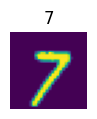

In [34]:
show_image(x, title=y.item());

A `collate` function that goes through the `dataset` items and stores independant(Image tensors) and dependant(labels) variables in a tuple like structure.

In [35]:
def collate(idxs, ds):
    xb, yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)

Checking the `collate` function with sample id list

In [38]:
x,y = collate([1,2], train_ds)
x.shape, y

(torch.Size([2, 28, 28]), tensor([7, 7]))

## DataLoader

In [39]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds, self.bs, self.shuffle, self.n_workers = ds, bs, shuffle, n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs +1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            for chunk in ex.map(collate, chunks, ds=self.ds):
                yield chunk

In [40]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=64, shuffle=True, n_workers=n_workers)
valid_dl  = DataLoader(valid_ds, bs=128, shuffle=False, n_workers=n_workers)
xb, yb = first(train_dl)
xb.shape, yb.shape, len(train_dl)

(torch.Size([64, 28, 28]), torch.Size([64]), 194)

In [43]:
dls = DataLoaders(train_dl, valid_dl)

## Loss Function

In [44]:
def mnist_loss(predictions, target):
    predictions = predictions.sigmoid()
    return torch.where(target==1, 1-predictions, predictions).mean()

## Optimizer

In [45]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad*self.lr

    def _zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

## Learner

In [56]:
class simple_learner:
    def __init__(self, dls, model, opt_func=BasicOptim, loss_func=mnist_loss, lr=0.01):
        self.dls = dls
        self.model = model
        self.opt_func = opt_func
        self.loss_func = loss_func
        self.lr = lr

    def calc_grad(self, xb, yb):
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        loss.backward()
        return loss
    
    def train_epochs(self):
        for xb,yb in self.dls[0]:
            self.calc_grad(xb, yb)
            self.opt.step()
            self.opt.zero_grad()

    def batch_accuracy(self, xb, yb):
        preds = xb.argmax(dim=1)
        return (preds==yb.squeeze()).float().mean()

    def validate_epochs(self):
        accs = [self.batch_accuracy(self.model(xb), yb) for xb,yb in self.dls[1]]
        return round(torch.stack(accs).mean().item(), 4)

    def fit(self, n_epochs):
        for i in range(n_epochs):
            self.train_epochs()
            print(self.validate_epoch(), end='\n')

In [57]:
model = nn.Linear(28*28, 1)
learn = Learner(dls, model)

AttributeError: 'DataLoader' object has no attribute 'train_ds'